In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as sp
import os as os
import multiprocessing
from joblib import Parallel, delayed
from time import time as ti
from skimage.restoration import denoise_wavelet
import pickle
#import CoreFunctions as cf
import sys
import random
import psutil

In [2]:
DataFolder = '/sciclone/scr10/dchendrickson01/Recordings2/'
DataFolder = '/scratch/Recordings2/'

DateString = '1011'
LastGoodModel = 8

TIME_STEPS = 1200
Skips = 125
RollSize = 50

LastSuccesfull = 10

tic = ti()
start = tic

MemoryProtection = True

LR_Starting = 3e-2
LR_PeriodGrow = 6
LR_Decay = .75
LR_Expand = 3.75

In [3]:
%matplotlib inline

In [4]:
RunTwice = True

In [5]:
FilesPerRun = 10
ConcurrentFiles = 5

In [6]:
def RollingStdDevFaster(RawData, SmoothData, RollSize = 25):

    Diffs = RawData - SmoothData
    del RawData, SmoothData
    
    Sqs = Diffs * Diffs
    del Diffs
    
    Sqs = Sqs.tolist() 
    Sqs.extend(np.zeros(RollSize))
    mSqs = np.matrix(Sqs)
    
    for i in range(RollSize):
        Sqs.insert(0, Sqs.pop())
        mSqs = np.concatenate((np.matrix(Sqs),mSqs))
    
    sVect = mSqs.sum(axis=0)
    eVect = (mSqs!=0).sum(axis=0)
    del mSqs, Sqs
    
    VarVect = sVect / eVect
    StdDevs = np.sqrt(VarVect)
    return np.asarray(StdDevs[:-RollSize].T)

def SquelchPattern(DataSet, StallRange = 5000, SquelchLevel = 0.02, verbose = False):
    
    SquelchSignal = np.ones(len(DataSet))
    if verbose:
        print(len(SquelchSignal))
        
    for i in range(len(DataSet)-2*StallRange):
        if np.average(DataSet[i:i+StallRange]) < SquelchLevel:
            SquelchSignal[i+StallRange]=0

    return SquelchSignal

def split_list_by_zeros(original_list, ones_list):
    # modified split_list_by_ones function to instead split by the zeros.
    #
    #
    # Created with Bing AI support
    #  1st request: "python split list into chunks based on value"
    #  2nd request: "I want to split the list based on the values in a second list.  Second list is all 1s and 0s.  I want all 0s removed, and each set of consequtive ones as its own item"
    #  3rd request: "That is close.  Here is an example of the two lists, and what I would want returned: original_list = [1, 2, 3, 8, 7, 4, 5, 6, 4, 7, 8, 9]
    #                ones_list =     [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]
    #                return: [[1, 2, 3, 8], [4, 5, 6], [8,9]]"
    #
    #This is the function that was created and seems to work on the short lists, going to use for long lists
    
    result_sublists = []
    sublist = []

    for val, is_one in zip(original_list, ones_list):
        if not is_one:
            sublist.append(val)
        elif sublist:
            result_sublists.append(sublist)
            sublist = []

    # Add the last sublist (if any)
    if sublist:
        result_sublists.append(sublist)

    return result_sublists

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS, skips = Skips):
    output = []
    for i in range(int((len(values) - time_steps + skips)/skips)):
        output.append(values[i*skips : (i*skips + time_steps)])
    return np.stack(output)

In [7]:
def runFile(file, verbose = False, small = False, index=0, start=ti()):
    noise = verbose
    if file[-4:] == '.csv':    
        dataset = pd.read_csv(DataFolder+file, delimiter =",", header=None, engine='python',on_bad_lines='skip')
        if noise:
            print("File Read", ti()-start)
        dataset = dataset.rename(columns={0:"Day"})
        dataset = dataset.rename(columns={1:"Second"})
        dataset = dataset.rename(columns={2:"FracSec"})
        dataset = dataset.rename(columns={3:"p"})
        dataset = dataset.rename(columns={4:"h"})
        dataset = dataset.rename(columns={5:"v"})
        dataset = dataset.rename(columns={6:"Sensor"})

        dataset['Second'].replace('',0)
        dataset['FracSec'].replace('',0)
        dataset.replace([np.nan, np.inf, -np.inf],0,inplace=True)
        
        dataset[['Day','Second']] = dataset[['Day','Second']].apply(lambda x: x.astype(int).astype(str).str.zfill(6))
        dataset[['FracSec']] = dataset[['FracSec']].apply(lambda x: x.astype(int).astype(str).str.zfill(4))

        dataset["timestamp"] = pd.to_datetime(dataset.Day+dataset.Second+dataset.FracSec,format='%y%m%d%H%M%S%f')
        dataset["timestamps"] = dataset["timestamp"]

        dataset["p"] = dataset.p - np.average(dataset.p)
        dataset["h"] = dataset.h - np.average(dataset.h)
        dataset["v"] = dataset.v - np.average(dataset.v)
        dataset["r"] = np.sqrt(dataset.p**2 + dataset.h**2 + dataset.v**2)

        dataset.index = dataset.timestamp

        dataset["SmoothP"] = denoise_wavelet(dataset.p, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        dataset["SmoothH"] = denoise_wavelet(dataset.h, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        dataset["SmoothV"] = denoise_wavelet(dataset.v, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        dataset["SmoothR"] = denoise_wavelet(dataset.r, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')

        if noise:
            print("Data Cleaned", ti()-start, len(dataset.p))

        RawData = dataset.v
        SmoothData = dataset.SmoothV
        RollSize = 25

        Diffs = RawData - SmoothData

        Sqs = Diffs * Diffs

        Sqs = Sqs.tolist() 

        Sqs.extend(np.zeros(RollSize))

        mSqs = np.matrix(Sqs)

        for i in range(RollSize):
            Sqs.insert(0, Sqs.pop())
            mSqs = np.concatenate((np.matrix(Sqs),mSqs))

        sVect = mSqs.sum(axis=0)
        eVect = (mSqs!=0).sum(axis=0)

        VarVect = sVect / eVect

        StdDevs = np.sqrt(VarVect)

        StdDevsZ = np.asarray(StdDevs)

        StdDevsZ=np.append(StdDevsZ,[0])

        StdDevsZ = np.asarray(StdDevsZ.T[:len(dataset.p)])

        if noise:
            print("Size StdDevsZ", ti()-start, np.shape(StdDevsZ))

        #StdDevsZ = np.nan_to_num(StdDevsZ)

        #StdDevsZ[StdDevsZ == np.inf] = 0
        #StdDevsZ[StdDevsZ == -np.inf] = 0

        if noise:
            print("cleaned", ti()-start, np.shape(StdDevsZ))

        SmoothDevZ = denoise_wavelet(StdDevsZ, method='VisuShrink', mode='soft', wavelet='sym2', rescale_sigma='True')

        if noise:
            print("denoise 1", ti()-start, np.shape(StdDevsZ))

        #SmoothDevZa = cf.Smoothing(StdDevsZ, 3, wvt='sym2', dets_to_remove=2, levels=3)
        #SmoothDevZ = np.ravel(SmoothDevZ[0,:])

        #SmoothDevZ = SmoothDevZ.tolist()

        if noise:
            print("denoise 2", ti()-start, np.shape(SmoothDevZ))

        #ataset["SmoothDevZ"] = SmoothDevZ

        SmoothDevZ[np.isnan(SmoothDevZ)]=0
        
        Max = np.max(SmoothDevZ)

        
        
        if noise:
            print("Max", ti()-start, np.shape(Max), Max)

        buckets = int(Max / 0.005) + 1
        bins = np.linspace(0,buckets*0.005,buckets+1)
        counts, bins = np.histogram(SmoothDevZ,bins=bins)

        CummCount = 0
        HalfWay = 0
        for i in range(len(counts)):
            CummCount += counts[i]
            if CummCount / len(SmoothDevZ) >= 0.5:
                if HalfWay == 0:
                    HalfWay = i

        SquelchLevel = bins[HalfWay] 
        if noise:
            print("SmoothDevz size", np.shape(SmoothDevZ))

        dataset["IsMoving"] = SquelchPattern(SmoothDevZ, 4000, SquelchLevel, verbose=noise)

        if noise:
            print("Squelch Made", ti()-start)
        #dataset["velocity"] = getVelocity(dataset.p, dataset.FracSec, dataset.IsMoving, 2)
        #if noise:
        #    print("Velocity Calculated.  File done: ",file)

        #df_pr = split_list_by_ones(dataset.p, dataset.IsMoving)
        #df_hr = split_list_by_ones(dataset.h, dataset.IsMoving)
        #df_vr = split_list_by_ones(dataset.v, dataset.IsMoving)
        #df_rrr = split_list_by_ones(dataset.r, dataset.IsMoving)
        df_ps = split_list_by_zeros(dataset.SmoothP, dataset.IsMoving)
        df_hs = split_list_by_zeros(dataset.SmoothH, dataset.IsMoving)
        df_vs = split_list_by_zeros(dataset.SmoothV, dataset.IsMoving)
        df_rs = split_list_by_zeros(dataset.SmoothR, dataset.IsMoving)

        del dataset
        
        MatsSmooth = []
        for i in range(len(df_ps)):
            MatsSmooth.append(np.vstack((df_ps[i],df_hs[i],df_vs[i],df_rs[i])))
        
        if verbose:
            print("Split by ones", ti()-start)


        '''df_p=[0]
        df_h=[0]
        df_v=[0]
        df_r=[0]
        df_rp=[0]
        df_rh=[0]
        df_rv=[0]
        df_rr=[0]
        for i in range(len(df_ps)):
            df_p += df_ps[i]
            df_h += df_hs[i]
            df_v += df_vs[i]
            df_r += df_rs[i]
            df_rp += df_pr[i]
            df_rh += df_hr[i]
            df_rv += df_vr[i]
            df_rr += df_rrr[i]
        '''
        if verbose:
            print('format changed', ti()-start, len(MatsSmooth))

        return MatsSmooth
    else:
        return ['fail','fail']
        
        #if verbose:
        #    print('Data normalized', ti()-start)

        #return df_p, df_h, df_v, df_r, df_rp, df_rh, df_rv, df_rr


In [8]:
if LastSuccesfull ==0:
    files= os.listdir(DataFolder) 
    random.shuffle(files)
    with open('CurrentFileList.text','w') as file:
        for item in files:
            file.write(f"{item}\n")
else:
    with open('CurrentFileList.text','r') as file:
        files = file.readlines()
    files=[item.strip() for item in files]

In [9]:
%%time
#df_p, df_h, df_v, df_r, 
Mats = runFile(files[0], verbose = True, small = False, index=0, start=ti())

File Read 120.31852412223816
Data Cleaned 208.10205173492432 26344221
Size StdDevsZ 240.2336926460266 (26344221,)
cleaned 240.23386073112488 (26344221,)
denoise 1 240.86375904083252 (26344221,)
denoise 2 240.8639166355133 (26344221,)
Max 240.88139462471008 () 0.03518209560253338
SmoothDevz size (26344221,)
26344221
Squelch Made 361.8815531730652
Split by ones 375.9740025997162
format changed 375.97422552108765 1724
CPU times: user 5min 51s, sys: 22.7 s, total: 6min 14s
Wall time: 6min 16s


In [10]:
def runWrapper(file_path, verbose=True, small=False, index=0, start=ti()):
    try:
        rtrn = runFile(file_path, verbose, small, index, start)
        return rtrn
    except Exception as e:
        with open('BadInputs.text', 'a') as bad_file:
            bad_file.write(file_path + '\n')
        return np.zeros((10, 10, 3))

In [11]:
%%time
AllDatas = Parallel(n_jobs=ConcurrentFiles)(delayed(runWrapper)(files[(i+1+LastSuccesfull*FilesPerRun)], False, False, 0, ti()) for i in range(FilesPerRun))

CPU times: user 443 ms, sys: 1.73 s, total: 2.17 s
Wall time: 12min 30s


In [12]:
for fileResponse in AllDatas:
    for Mat in fileResponse:
        Mats.append(Mat)

In [13]:
len(Mats)

6822

In [14]:
import CoreFunctions as cf

In [15]:
lengths = []
rejects = []
Keeps = []

In [16]:
for Mat in Mats:
    spm = np.shape(Mat)
    if len(spm) > 1:
        lenM = spm[1]
    else:
        lenM = 1
    if (lenM > 1250):
        lengths.append(lenM)
        Keeps.append(Mat)
    else:
        rejects.append(lenM)

In [17]:
if MemoryProtection:
    print('RAM memory % used:', psutil.virtual_memory()[2])
    del Mats, AllDatas


RAM memory % used: 7.7


In [18]:
len(lengths) / (len(lengths)+len(rejects))

0.27440633245382584

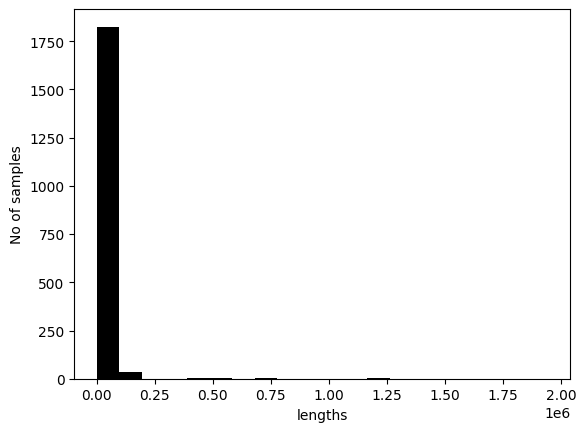

In [19]:
plt.hist(lengths, bins=20)
plt.xlabel("lengths")
plt.ylabel("No of samples")
plt.show()


In [20]:
Prints = []


In [21]:
np.shape(Keeps[3])

(4, 1780)

In [22]:
def PrintWrap(Mat):
    localPrints = []
    lenm = np.shape(Mat)[1]
    slices = int(lenm/TIME_STEPS)
    for i in range(slices):
        temp = (cf.makeMPFast(Mat[:3,i*TIME_STEPS:(i+1)*TIME_STEPS], wvt = 'sym4', scales = 32, spacer = 2, title = ''))
        localPrints.append(temp.astype(np.float32)/255.0)
    return localPrints

In [23]:
%%time
AllPrints = Parallel(n_jobs=8)(delayed(PrintWrap)(Mat) for Mat in Keeps)

CPU times: user 5.26 s, sys: 23.7 s, total: 29 s
Wall time: 55 s


In [24]:
if MemoryProtection:
    print('RAM memory % used:', psutil.virtual_memory()[2])
    del Keeps

RAM memory % used: 14.5


In [25]:
for group in AllPrints:
    for fprint in group:
        Prints.append(fprint[:, ::2, :])

for Mat in Keeps:
    lenm = np.shape(Mat)[1]
    slices = int(lenm/TIME_STEPS)
    for i in range(slices):
        temp = (cf.makeMPFast(Mat[:3,i*TIME_STEPS:(i+1)*TIME_STEPS], wvt = 'sym4', scales = 60, spacer = 1, title = ''))
        Prints.append(temp.astype(np.float32)/255.0)

In [26]:
if MemoryProtection:
    print('RAM memory % used:', psutil.virtual_memory()[2])
    del AllPrints


RAM memory % used: 14.4


np.shape(Prints)

In [27]:
len(Prints)

28256

In [28]:
np.max(Prints[1])

1.0

In [29]:
for i in range(7):
    print(np.shape(Prints[i*13]))

(32, 600, 3)
(32, 600, 3)
(32, 600, 3)
(32, 600, 3)
(32, 600, 3)
(32, 600, 3)
(32, 600, 3)


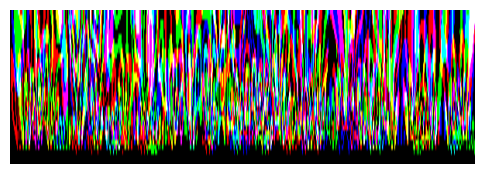

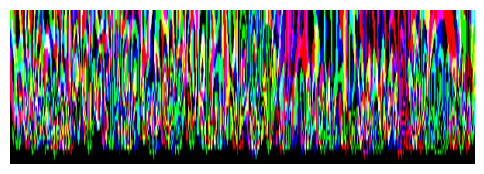

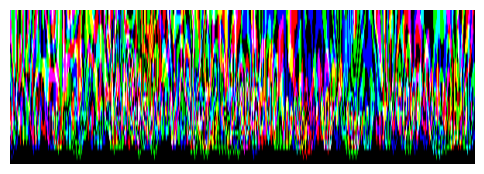

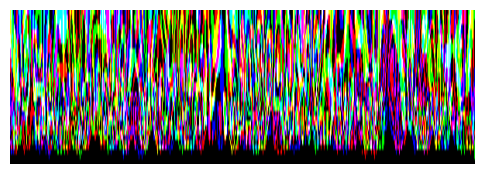

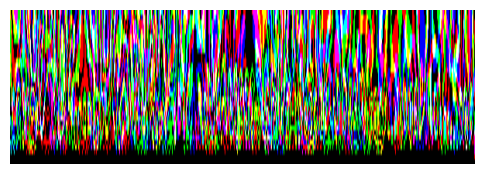

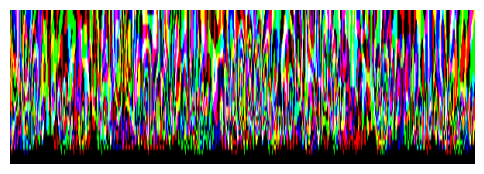

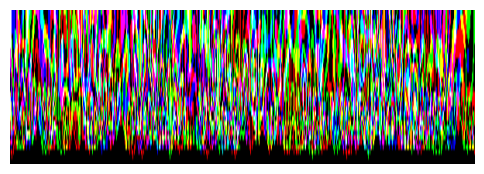

In [30]:
for i in range(7):
    fig = plt.figure(figsize=(6,2), dpi=100)
    plt.axis("off")
    plt.imshow(Prints[i*13], origin='lower',aspect='auto')
    plt.show()

# Start Machine Learning
## Using Autoencoder with Kears and Tensorflow
cite: https://pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/

In [31]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

2024-10-13 20:23:23.812986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 20:23:23.825425: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 20:23:23.829309: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 20:23:23.839491: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=24):
        inputShape = (height, width, depth)
        chanDim = -1
        inputs = Input(shape=inputShape)
        x = inputs

        for f in filters:
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        volumeSize = K.int_shape(x)
        print("Volume Size:", volumeSize)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)

        encoder = Model(inputs, latent, name="encoder")

        latentInputs = Input(shape=(latentDim,))
        flattenedVolumeSize = int(np.prod(volumeSize[1:]))
        print("Flattened Volume Size:", flattenedVolumeSize)
        x = Dense(flattenedVolumeSize)(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

        for f in filters[::-1]:
            x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)

        decoder = Model(latentInputs, outputs, name="decoder")
        autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

        return (encoder, decoder, autoencoder)


In [33]:
# set the matplotlib backend so figures can be saved in the background
#import matplotlib
#matplotlib.use("Agg")
# import the necessary packages
#from pyimagesearch.convautoencoder import ConvAutoencoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
# construct the argument parse and parse the arguments

In [34]:
import random
import tensorflow as tf
from tensorflow.keras.models import load_model

In [35]:
from tensorflow.keras.callbacks import Callback

In [36]:
import keras
import re

In [37]:
# initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 128
TestSplit = 10 # 1/this many

# load the MNIST dataset

random.shuffle(Prints)

TestLength = int(len(Prints)/TestSplit)

In [38]:
np.shape(Prints)

(28256, 32, 600, 3)

In [39]:
print(type(Prints))
print(Prints[0].dtype)
print(np.shape(Prints))
print('RAM memory % used:', psutil.virtual_memory()[2])

<class 'list'>
float32
(28256, 32, 600, 3)
RAM memory % used: 14.5



# Assuming 'Prints' is your list

# Convert the list to a NumPy array with a consistent data type
try:
    prints_array = np.array(Prints, dtype=np.float32)
except Exception as e:
    print(f"Error converting to NumPy array: {e}")

# Check the shape and type of the NumPy array
print(f"Shape of prints_array: {prints_array.shape}")
print(f"Data type of prints_array: {prints_array.dtype}")

# Convert the NumPy array to a TensorFlow tensor
try:
    tensor_prints = tf.convert_to_tensor(prints_array)
    print(tensor_prints)
except Exception as e:
    print(f"Error converting to TensorFlow tensor: {e}")


In [40]:
for i, image in enumerate(Prints):
    if not isinstance(image, np.ndarray):
        Prints[i] = np.array(image, dtype=np.float32)
    elif image.dtype != np.float32:
        Prints[i] = image.astype(np.float32)

# Stack the images into a single NumPy array
prints_array = np.stack(Prints, axis=0)

if MemoryProtection:
    del Prints
    print('RAM memory % used:', psutil.virtual_memory()[2])

RAM memory % used: 19.3


In [41]:
if psutil.virtual_memory()[2] > 49:
    temp = (float(psutil.virtual_memory()[2]) - 50.0) / 50.0
    temp2 = int(np.shape(prints_array)[0]*temp)
    prints_array = prints_array[:temp2]

In [42]:
np.shape(prints_array)

(28256, 32, 600, 3)

In [43]:
# Convert the NumPy array to a TensorFlow tensor
tensor_prints = tf.convert_to_tensor(prints_array)

2024-10-13 20:23:46.285191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43598 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:21:00.0, compute capability: 8.6
2024-10-13 20:23:46.288742: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6510182400 exceeds 10% of free system memory.


In [44]:
ImageShape = np.shape(tensor_prints)

In [45]:
if MemoryProtection:
    del prints_array
    print('RAM memory % used:', psutil.virtual_memory()[2])

RAM memory % used: 20.5


NP = []
for prt in Prints:
    temp = tf.convert_to_tensor(prt)
    NP.append(temp)
NP = tf.onvert_to_tensor(NP)

trainX = np.asarray(Prints[:TestLength]).astype('float32')

testX = Prints[TestLength:]

In [46]:
trX = tensor_prints[:TestLength]  #tf.convert_to_tensor(trainX, dtype=tf.float32)

In [47]:
teX = tensor_prints[TestLength:]  #tf.convert_to_tensor(testX, dtype=tf.float32)

In [48]:
if MemoryProtection:
    del tensor_prints

In [49]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")

[INFO] building autoencoder...


In [50]:
if LastSuccesfull == 0:
    (encoder, decoder, autoencoder) = ConvAutoencoder.build(ImageShape[2], ImageShape[1], ImageShape[3],(64,32),32)
else:

    directory = '/scratch/models/'

    # Regular expression to match the filenames
    pattern = re.compile(r'3DFP_(\d{4})_(\d{3})autoencoder\.keras')
    
    # Initialize variables to track the highest numbers
    max_main_number = -1
    max_sub_number = -1
    target_file = None
    
    # Iterate over the files in the directory
    '''
    file_list = os.listdir(directory)
    for filename in file_list:
        match = pattern.match(filename)
        if match:
            main_number = int(match.group(1))
            sub_number = int(match.group(2))
            
            # Check if this file has the highest main number
            if main_number > max_main_number: # or (main_number == max_main_number and sub_number > max_sub_number):
                max_main_number = main_number
                
    for filename in file_list:
        match = pattern.match(filename)
        if match:
            main_number = int(match.group(1))
            sub_number = int(match.group(2))
        
            if main_number==max_main_number and sub_number > max_sub_number:
                max_sub_number = sub_number
                target_file = filename
    '''
    target_file = f'3DFP_{DateString}_{str(LastGoodModel).zfill(3)}autoencoder.keras'
    reautoencoder = load_model(directory+target_file)
    encoder = load_model(directory+target_file[:-17]+'encoder.keras')
    decoder = load_model(directory+target_file[:-17]+'decoder.keras')

    autoencoder_input = Input(shape=(ImageShape[1], ImageShape[2], ImageShape[3]))

    # Pass the input through the encoder and decoder
    encoded_repr = encoder(autoencoder_input)
    reconstructed = decoder(encoded_repr)

    # Create the reassembled autoencoder model
    autoencoder = Model(autoencoder_input, reconstructed)

In [51]:
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())
if LastSuccesfull != 0:
    print(reautoencoder.summary())

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 600, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 300, 64)    │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 300, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 300, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 150, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 150, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 150, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,228,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,249,472 (4.77 MB)

 Trainable params: 1,249,280 (4.77 MB)

 Non-trainable params: 192 (768.00 B)

None


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38400)          │     1,267,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 150, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 300, 32)    │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 300, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 300, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 600, 64)    │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 600, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 600, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 600, 3)     │         1,731 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 600, 3)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,297,059 (4.95 MB)

 Trainable params: 1,296,867 (4.95 MB)

 Non-trainable params: 192 (768.00 B)

None


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 600, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │     1,249,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 600, 3)     │     1,297,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,546,531 (9.71 MB)

 Trainable params: 2,546,147 (9.71 MB)

 Non-trainable params: 384 (1.50 KB)

None


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 600, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │     1,249,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 600, 3)     │     1,297,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,638,827 (29.14 MB)

 Trainable params: 2,546,147 (9.71 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 5,092,296 (19.43 MB)

None


In [52]:
opt = Adam(learning_rate=LR_Starting)
autoencoder.compile(loss="mse", optimizer=opt)
# train the convolutional autoencoder

In [53]:

class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, save_freq):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.filepath.format(epoch=epoch + 1))

In [54]:
checkpoint_callback = CustomModelCheckpoint(
    filepath='/scratch/models/3DFP_'+DateString+'_00_{epoch:02d}.keras',
    save_freq=3  
)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir='/scratch/models/profiles/'+DateString,
                                            profile_batch='01, 125')

es_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=6, mode="min")

2024-10-13 20:23:49.986707: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2024-10-13 20:23:49.986755: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2024-10-13 20:23:49.986833: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:892] Profiler found 1 GPUs
2024-10-13 20:23:50.018631: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.
2024-10-13 20:23:50.018734: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1036] CUPTI activity buffer flushed


In [55]:
H = autoencoder.fit(
	trX, trX,
	validation_data=(teX, teX),
	epochs=25,
    #callbacks=[checkpoint_callback, es_callback],     
	batch_size=BS*2)

Epoch 1/25


I0000 00:00:1728865432.903851  740337 service.cc:146] XLA service 0x150618217820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728865432.903907  740337 service.cc:154]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-10-13 20:23:52.953794: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-13 20:23:53.179695: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.2033

I0000 00:00:1728865444.522627  740337 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 919ms/step - loss: 0.2048 - val_loss: 0.2060
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step - loss: 0.2025 - val_loss: 0.2039
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 390ms/step - loss: 0.2023 - val_loss: 0.2047
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - loss: 0.2017 - val_loss: 0.2045
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 394ms/step - loss: 0.2021 - val_loss: 0.2048
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - loss: 0.2016 - val_loss: 0.2042
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 396ms/step - loss: 0.2016 - val_loss: 0.2031
Epoch 8/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - loss: 0.2016 - val_loss: 0.2032
Epoch 9/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 390ms/step - loss: 0.2014 - val_loss: 0.2031
Epoch 10/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/step - loss: 0.2011 - val_loss: 0.2027
Epoch 11/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 390ms/step - loss: 0.2014 - val_loss: 0.2023
Epoch 12/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 390ms/step - loss: 0

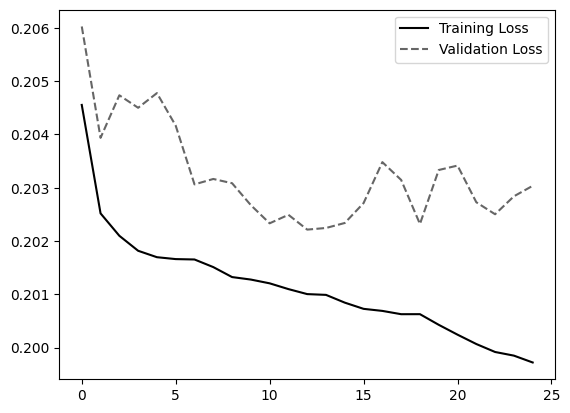

In [56]:
plt.plot(H.history["loss"], label="Training Loss")
plt.plot(H.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [57]:
x_train_pred = autoencoder.predict(teX[:1000])

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


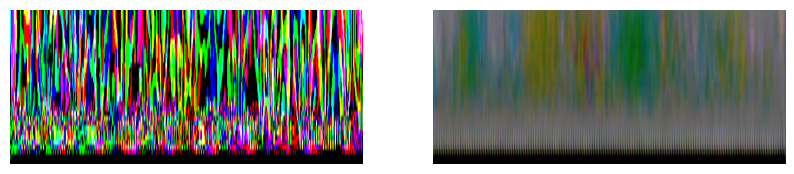

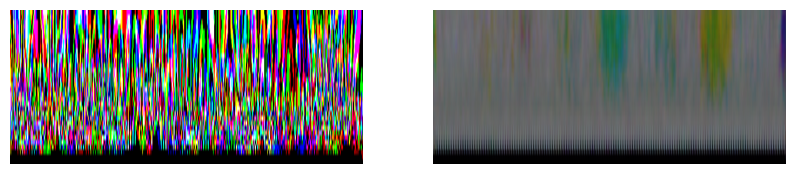

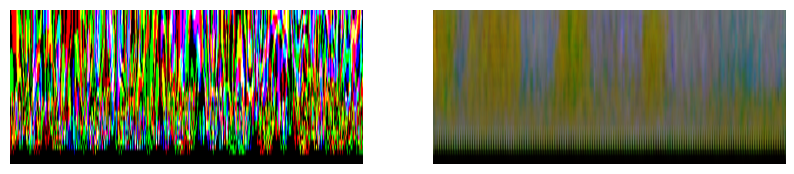

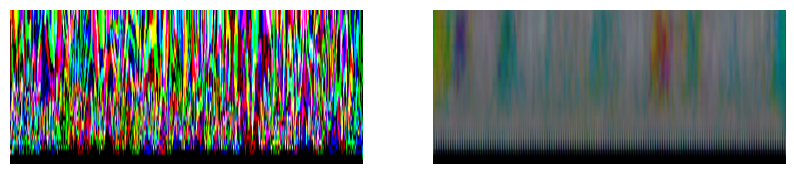

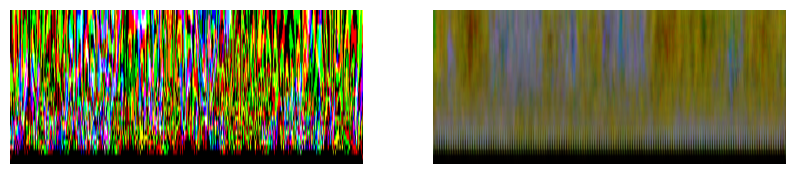

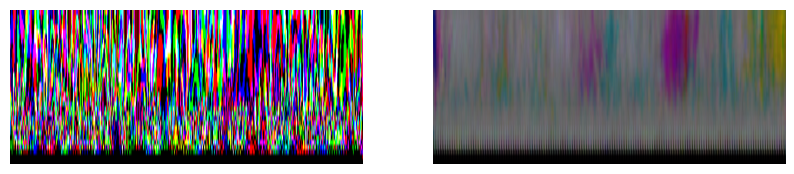

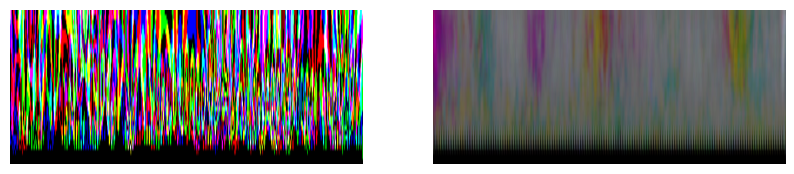

In [58]:

for i in range(7):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,2), dpi=100 )
    ax1.imshow(teX[i*13], origin='lower',aspect='auto')
    ax1.axis("off")
    ax2.imshow(x_train_pred[i*13], origin='lower',aspect='auto')
    plt.axis("off")
    plt.show()

In [59]:
del trX, teX

In [60]:
del x_train_pred

In [61]:
toc = ti()
LR_Current = LR_Starting

In [62]:
j = LastSuccesfull + 1
autoencoder.save('/scratch/models/3DFP_'+DateString+'_'+str(j).zfill(3)+'autoencoder.keras')
encoder.save('/scratch/models/3DFP_'+DateString+'_'+str(j).zfill(3)+'encoder.keras')
decoder.save('/scratch/models/3DFP_'+DateString+'_'+str(j).zfill(3)+'decoder.keras')

Loops Needed: 96
RAM after AllData: 11.7
RAM after Keeps: 23.1
RAM after Prints: 27.9


2024-10-13 20:38:41.072721: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 7938432000 exceeds 10% of free system memory.
2024-10-13 20:38:45.227129: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 7144473600 exceeds 10% of free system memory.
2024-10-13 20:38:46.056476: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 7144473600 exceeds 10% of free system memory.


Epoch 1/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - loss: 0.2074 - val_loss: 0.2078
Epoch 2/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.2069 - val_loss: 0.2070
Epoch 3/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.2069 - val_loss: 0.2071
Epoch 4/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - loss: 0.2067 - val_loss: 0.2071
Epoch 5/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.2068 - val_loss: 0.2071
Epoch 6/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.2066 - val_loss: 0.2070
Epoch 7/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.2068 - val_loss: 0.2071
Epoch 8/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.2064 - val_loss: 0.2072
Epoch 9/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.2064 - val_loss: 0.2071
Epoch 10/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.2064 - val_loss: 0.2072
Epoch 11/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.2064 - val_loss: 0.2074
Epoch 12/20
243/243 ━━━━━━━━━━

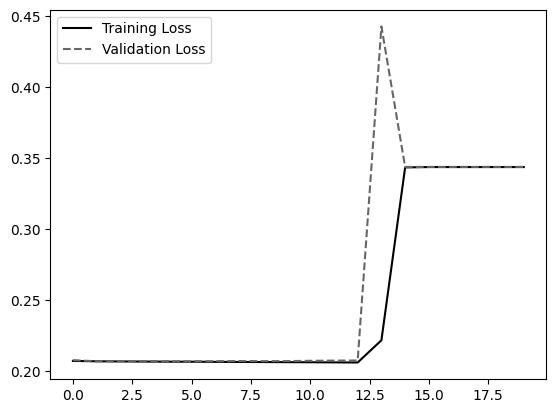

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


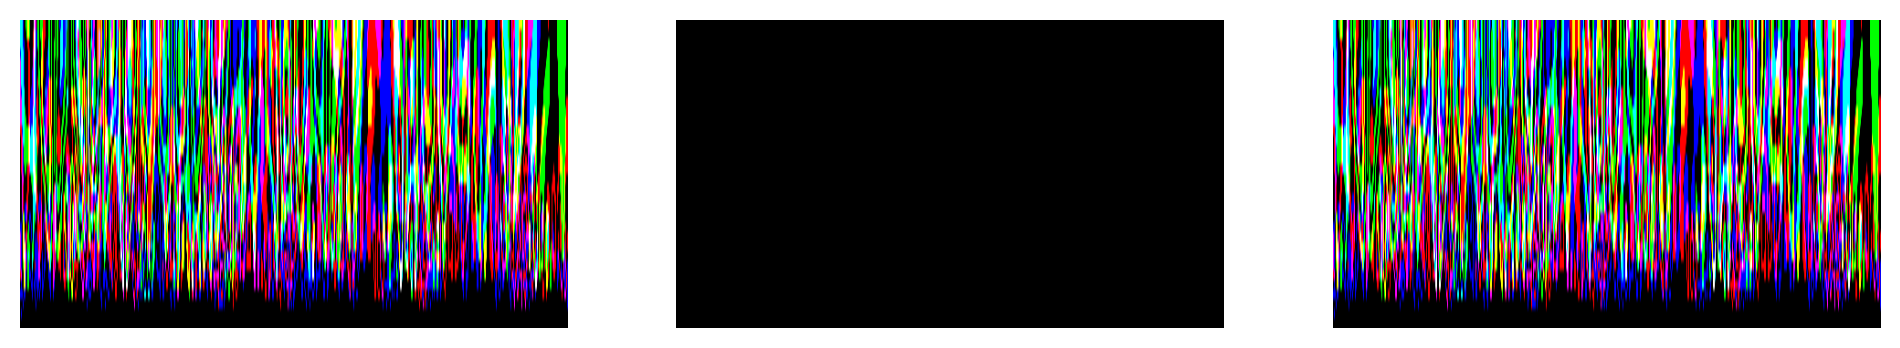

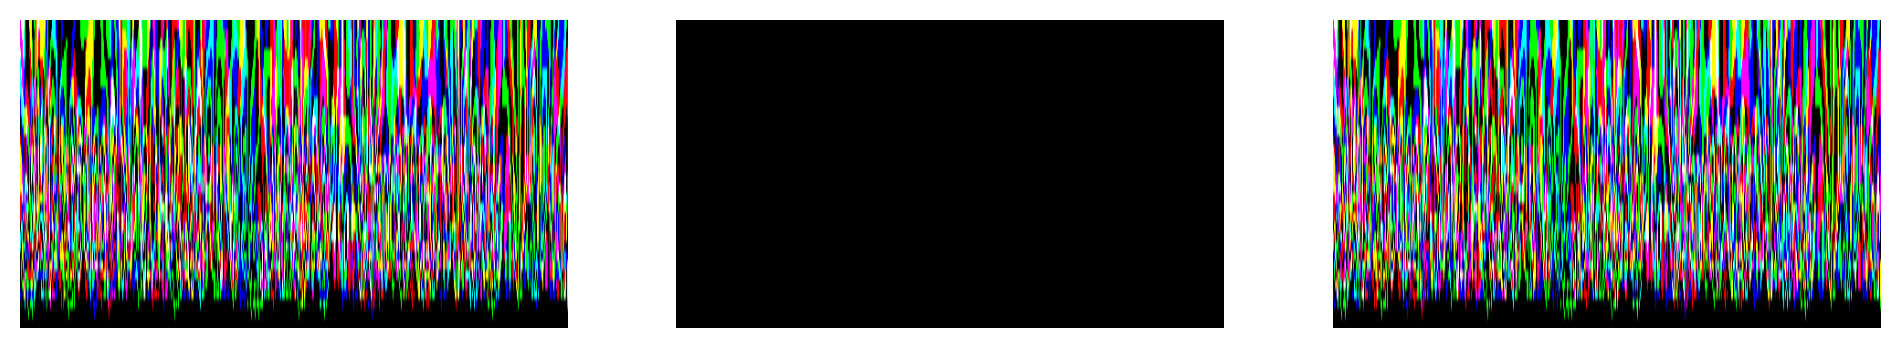

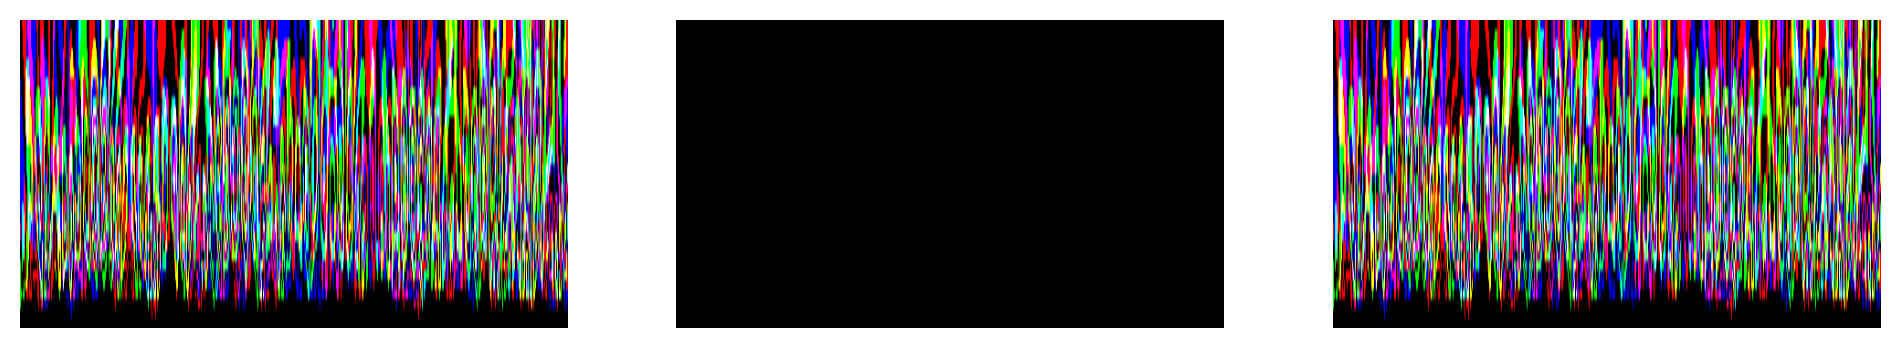

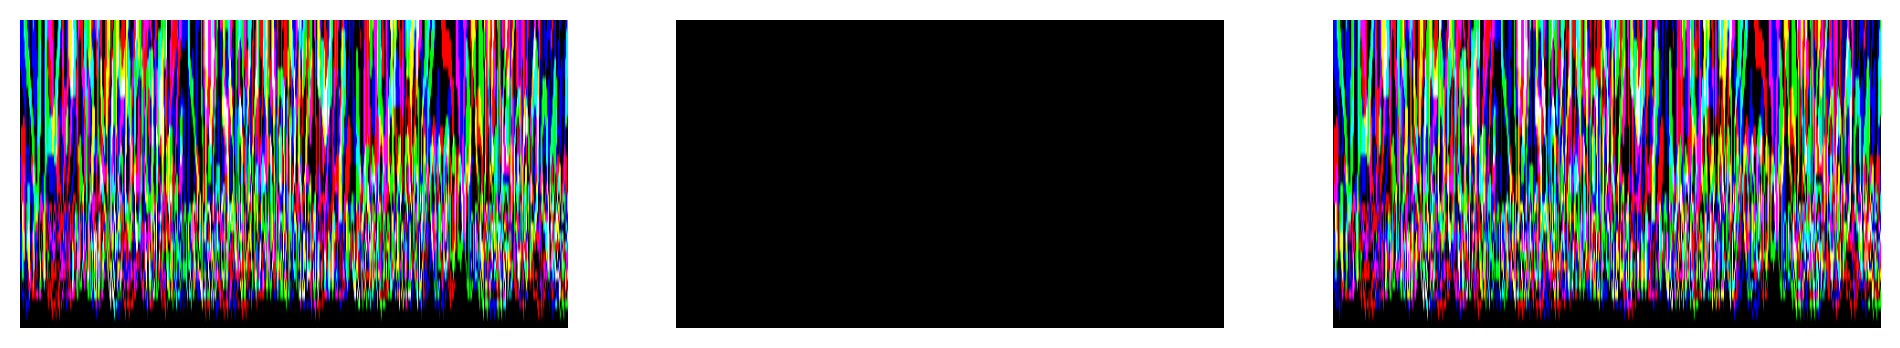

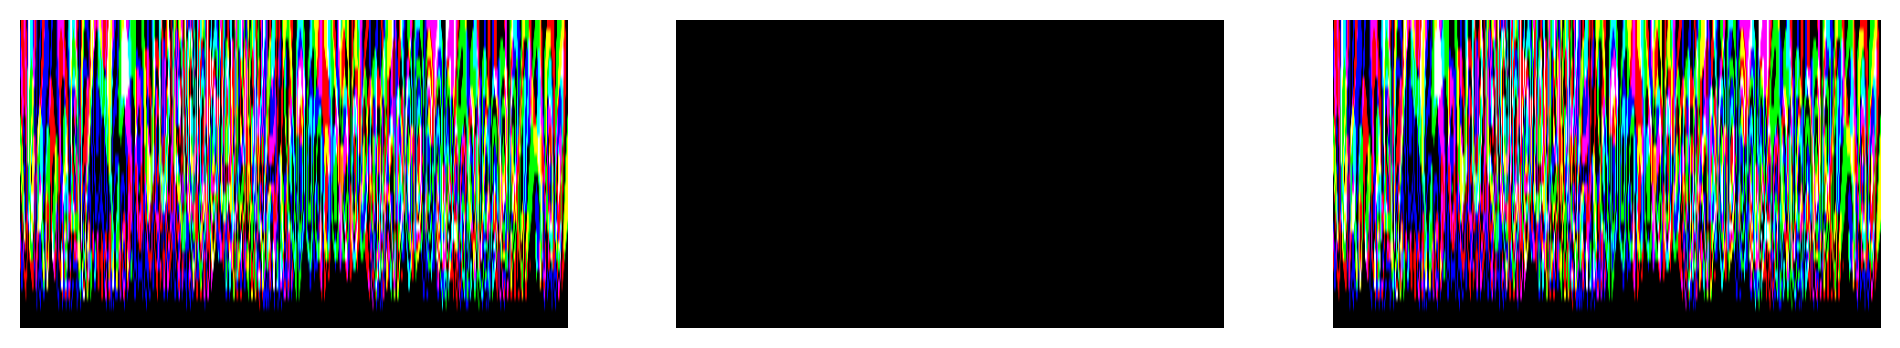

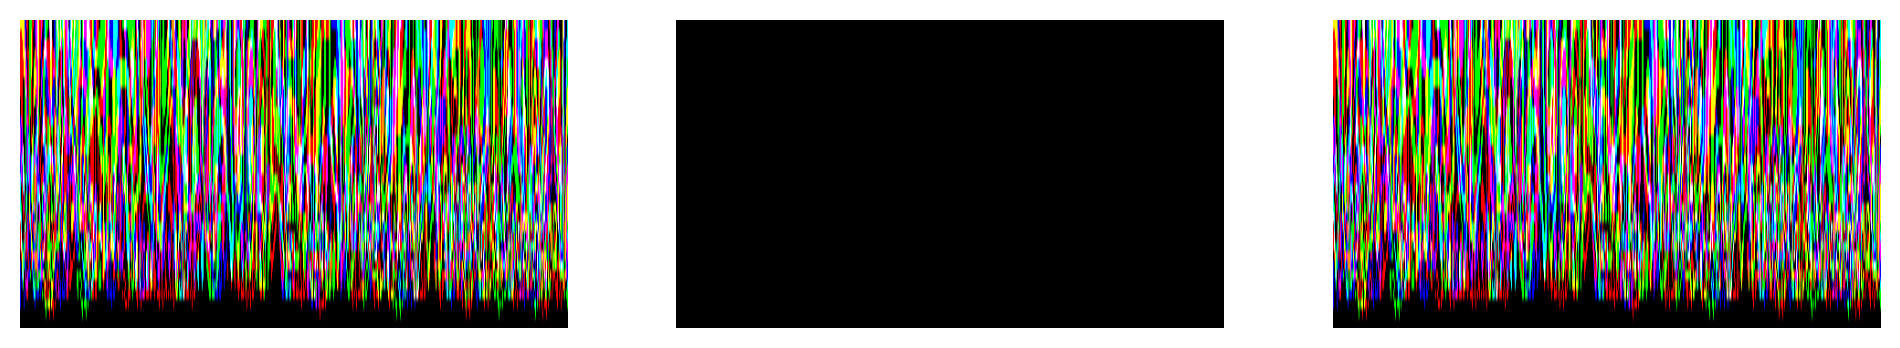

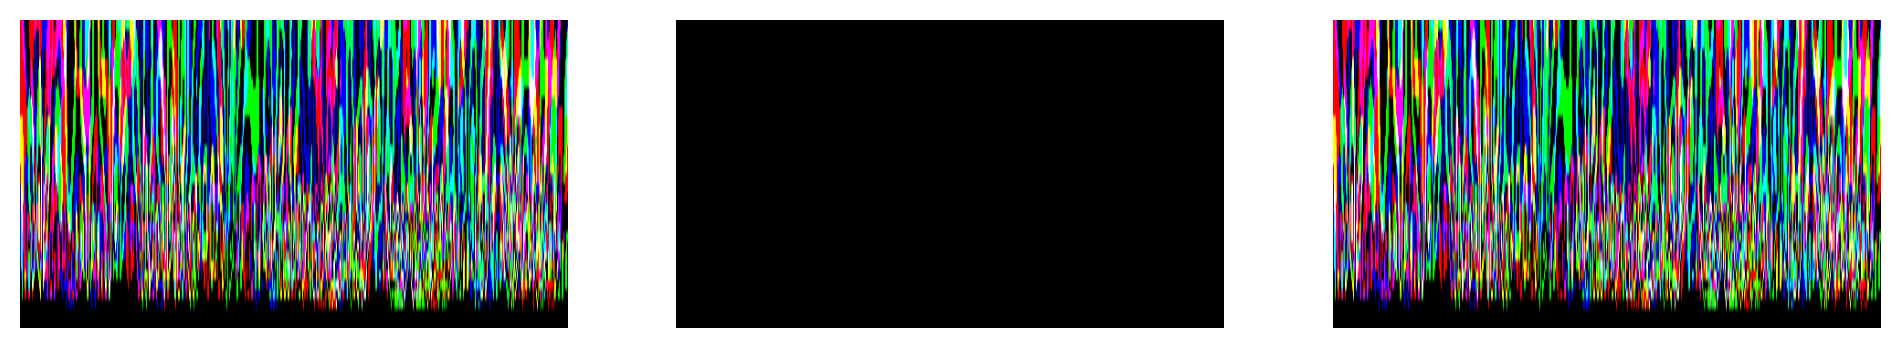

11 of 96 in 17.09 minutes. Using 46.1 of RAM
RAM after AllData: 44.1
RAM after Keeps: 44.4
RAM after Prints: 50.8


2024-10-13 20:56:57.014141: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8604979200 exceeds 10% of free system memory.


Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - loss: 0.3393 - val_loss: 0.3388
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - loss: 0.3393 - val_loss: 0.3388
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - loss: 0.3393 - val_loss: 0.3388
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - loss: 0.3393 - val_loss: 0.3388
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - loss: 0.3392 - val_loss: 0.3388
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - loss: 0.3391 - val_loss: 0.3388
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - loss: 0.3393 - val_loss: 0.3388
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - loss: 0.3393 - val_loss: 0.3388
Epoch 9/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - loss: 0.3393 - val_loss: 0.3388
Epoch 10/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - loss: 0.3392 - val_loss: 0.3388
Epoch 11/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - loss: 0.3391 - val_loss: 0.3388
Epoch 12/20
263/263 ━━━━━━━━━━

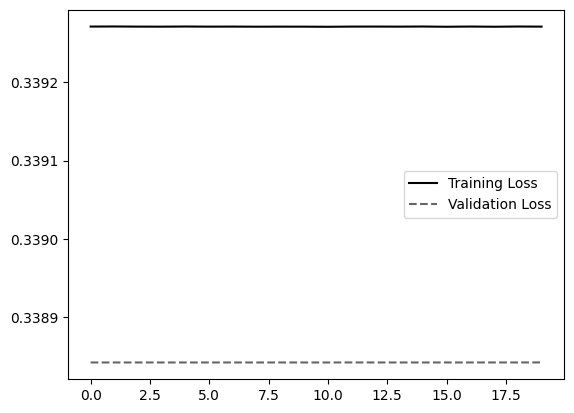

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


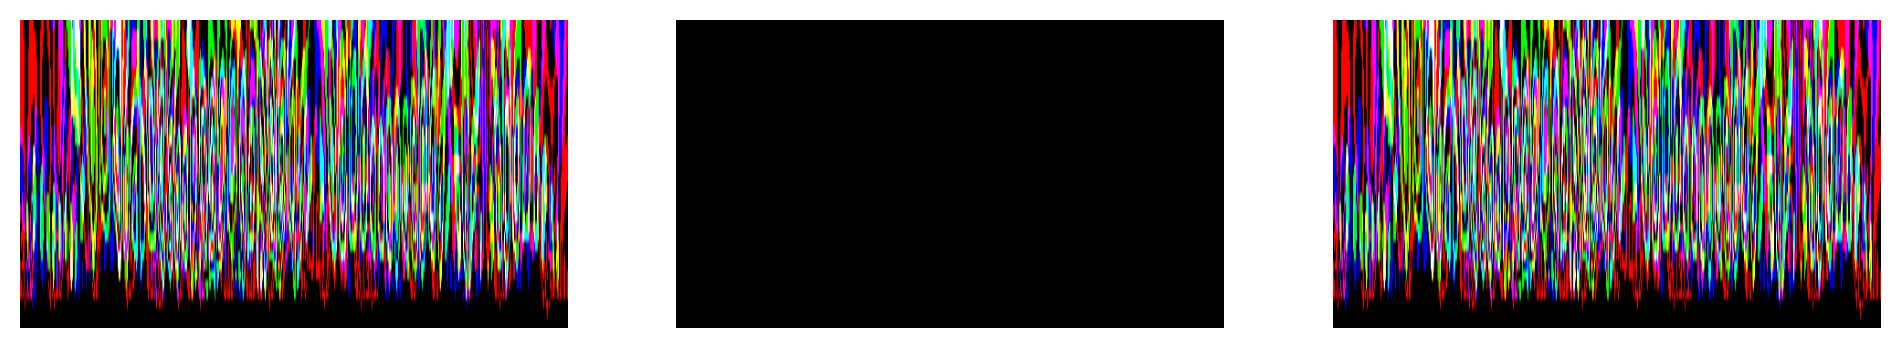

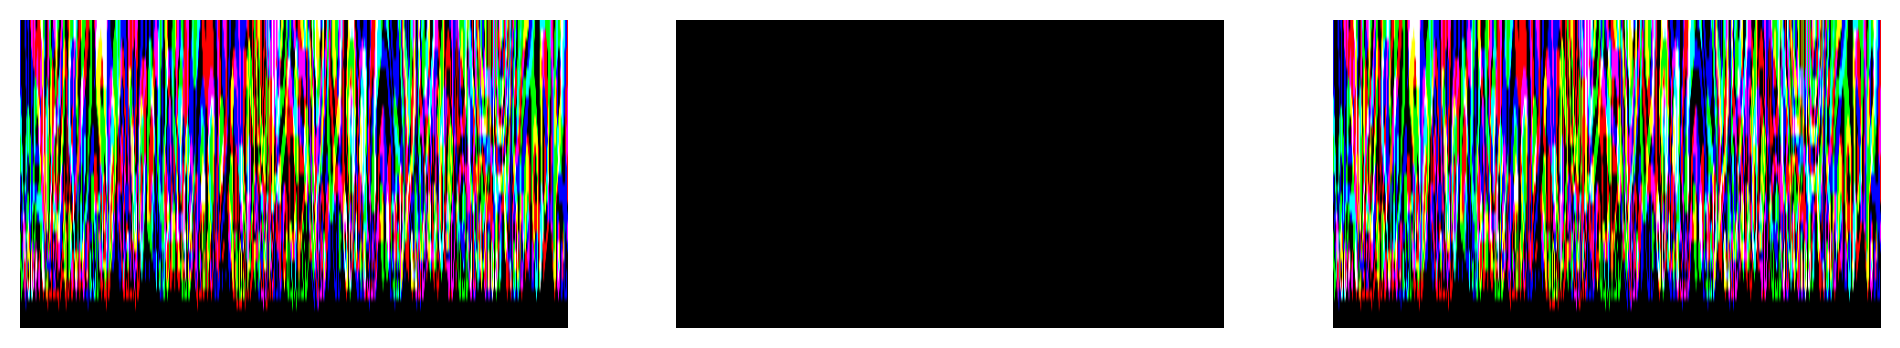

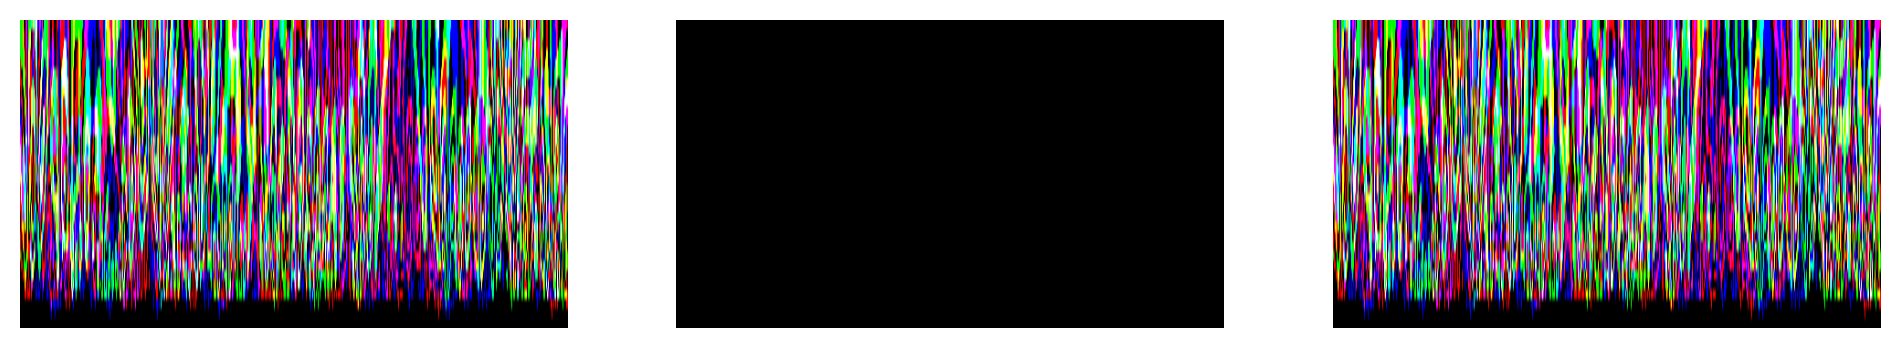

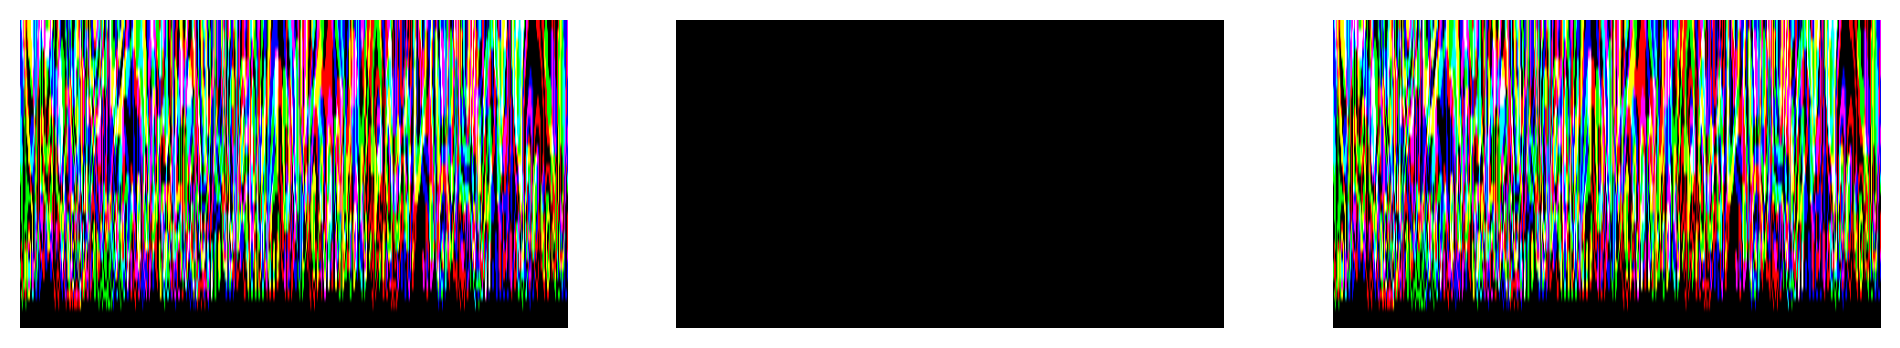

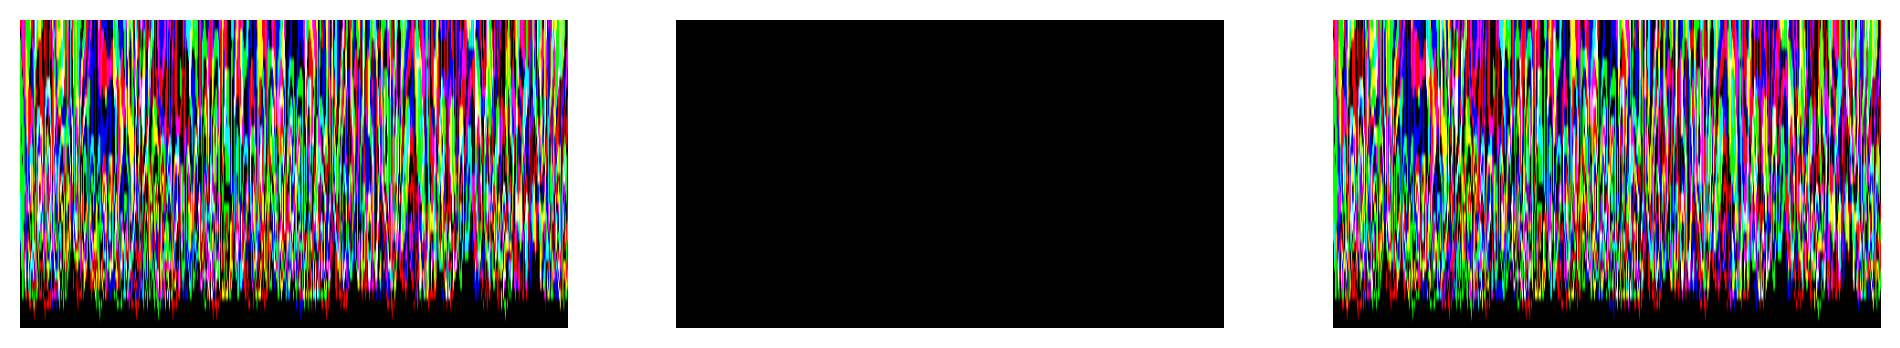

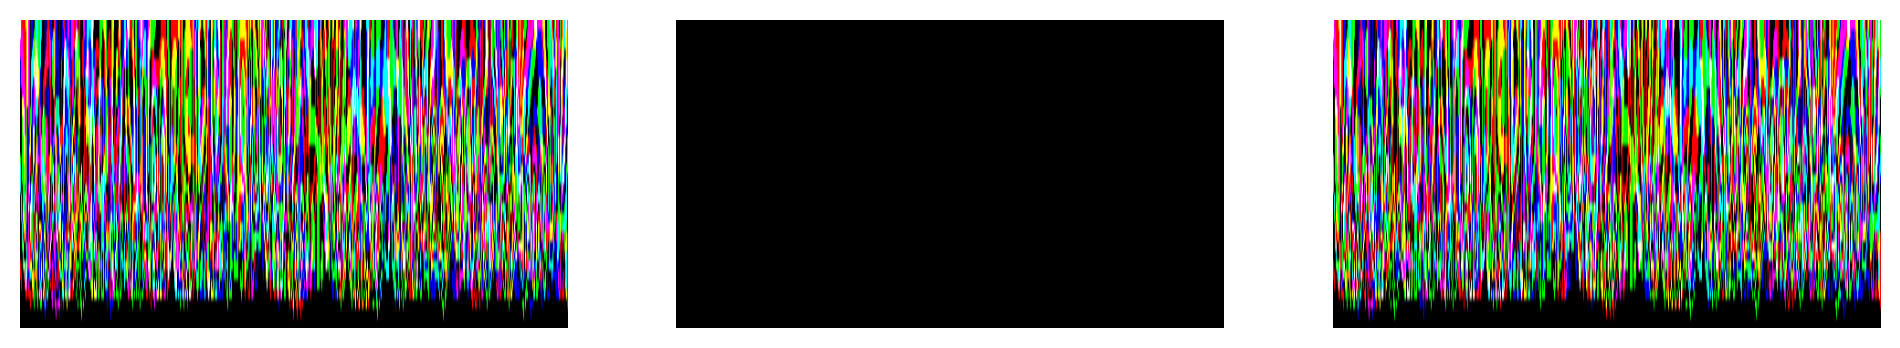

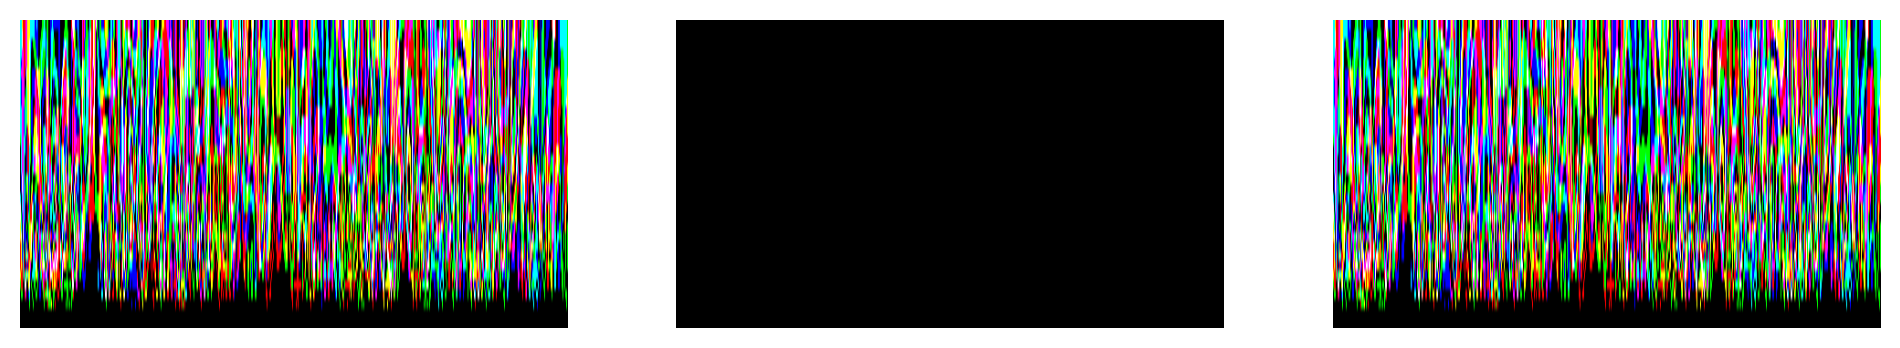

12 of 96 in 35.68 minutes. Using 61.2 of RAM


In [ ]:
if RunTwice:
    LoopsToGetAll = int(len(files)/FilesPerRun)-LastSuccesfull-1
    print(f'Loops Needed: {LoopsToGetAll}')
    for j in range(LoopsToGetAll):
        j+=1+LastSuccesfull
        Mats=[]
        AllDatas = Parallel(n_jobs=ConcurrentFiles)(delayed(runWrapper)(files[(j*FilesPerRun+i)], False, False, 0, ti()) for i in range(FilesPerRun))
        for fileResponse in AllDatas:
            for Mat in fileResponse:
                Mats.append(Mat)
        
        if MemoryProtection:
            del AllDatas
            print('RAM after AllData:', psutil.virtual_memory()[2])        
        lengths = []
        rejects = []
        Keeps = []
        
        for Mat in Mats:
            spm = np.shape(Mat)
            if len(spm) > 1:
                lenM = spm[1]
            else:
                lenM = 1
            if (lenM > 1250):
                lengths.append(lenM)
                Keeps.append(Mat)
            else:
                rejects.append(lenM)
        
        if MemoryProtection:
            del Mats
        
        Prints = []
        
        
        AllPrints = Parallel(n_jobs=8)(delayed(PrintWrap)(Mat) for Mat in Keeps)
        
        if MemoryProtection:
            del Keeps
            print('RAM after Keeps:', psutil.virtual_memory()[2])
        for group in AllPrints:
            for fprint in group:
                Prints.append(fprint[:, ::2, :])
        
        if MemoryProtection:
            del AllPrints
        
        
        random.shuffle(Prints)
        
        for i, image in enumerate(Prints):
            if not isinstance(image, np.ndarray):
                Prints[i] = np.array(image, dtype=np.float32)
            elif image.dtype != np.float32:
                Prints[i] = image.astype(np.float32)
        
        # Stack the images into a single NumPy array
        prints_array = np.stack(Prints, axis=0)
        
        if MemoryProtection:
            del Prints
            print('RAM after Prints:', psutil.virtual_memory()[2])
        # Convert the NumPy array to a TensorFlow tensor
        trX = tf.convert_to_tensor(prints_array)
        
        if MemoryProtection:
            del prints_array
        
        ImageShape = np.shape(trX)
        
        #trX = tensor_prints[:TestLength]  #tf.convert_to_tensor(trainX, dtype=tf.float32)
        
        #teX = tensor_prints[TestLength:]  #tf.convert_to_tensor(testX, dtype=tf.float32)
        
        #if MemoryProtection:
        #    del tensor_prints
        
        #checkpoint_callback = CustomModelCheckpoint(
        #    filepath='/scratch/models/3DFP_'+DateString+'_'+str(j)+'_{epoch:02d}.keras',
        #    save_freq=3  
        #)
        
        H = autoencoder.fit(
        	trX, trX,
        	validation_split=0.1,
        	epochs=20,
            #callbacks=[checkpoint_callback, es_callback],     
        	batch_size=BS)
        
        plt.plot(H.history["loss"], label="Training Loss")
        plt.plot(H.history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.show()

        #random.shuffle(trX)
        autoencoder.save('/scratch/models/3DFP_'+DateString+'_'+str(j).zfill(3)+'autoencoder.keras')
        encoder.save('/scratch/models/3DFP_'+DateString+'_'+str(j).zfill(3)+'encoder.keras')
        decoder.save('/scratch/models/3DFP_'+DateString+'_'+str(j).zfill(3)+'decoder.keras')

        
        x_train_pred = autoencoder.predict(trX[:7])
        
        for i in range(7):
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12,2), dpi=200 )
            ax1.imshow(trX[i], origin='lower',aspect='auto')
            ax1.axis("off")
            ax2.imshow(x_train_pred[i], origin='lower',aspect='auto')
            ax2.axis("off")
            ax3.imshow(np.abs(trX[i]-x_train_pred[i]), origin='lower',aspect='auto')
            ax3.axis("off")
            plt.show()

        del trX, x_train_pred, fig, ax1,ax2,ax3

        if j%LR_PeriodGrow == 0:
            LR_Current *= LR_Expand
        else:
            LR_Current *= LR_Decay
            
        autoencoder.optimizer.learning_rate = LR_Current
    
        print(f'{j} of {LoopsToGetAll} in {int((ti()-toc)/.6)/100} minutes. Using { psutil.virtual_memory()[2]} of RAM')